In [24]:
from helpers import *
from spice_net import *

import numpy as np
import networkx as nxs
import tqdm
import random
import json

import PySpice
PySpice.Spice.Simulation.CircuitSimulator.DEFAULT_SIMULATOR = "ngspice-shared" 
import PySpice.Spice.NgSpice.Server
PySpice.Spice.NgSpice.Server.SpiceServer.SPICE_COMMAND = 'ngspice'

In [2]:
import PySpice.Spice.NgSpice.Shared

instance = PySpice.Spice.NgSpice.Shared.NgSpiceShared.new_instance()

Unsupported Ngspice version 43


In [3]:
data = np.load("../data/xor_train_data_no_scale.npz")

In [4]:
def make_test_net(size, instance):
    seed = 0

    grid_size = size

    np.random.seed(seed)

    grid_graph = nx.grid_graph([grid_size, grid_size], periodic=True)
    grid_graph.add_node((-1, -1))

    for e in grid_graph.edges:
        grid_graph[e[0]][e[1]]['weight'] = 0.5                           # init to max value
        grid_graph[e[0]][e[1]]['weight'] = random.uniform(0.1, 0.9)       # random value

    node_cfg = (np.array([[5, 16], [7, 16], [13, 16], [15, 16]]), np.array([[10, 0]]))
    net: TransistorNetwork = TransistorNetwork("profiling", con_graph=grid_graph, node_cfg=node_cfg, solver=instance, epsilon=1e-16)
    return net

In [5]:
net = make_test_net(4, instance)

In [6]:
print(net)

.title profiling
.subckt Transistor_edge t_D t_S vgs=0.5
V1 t_G t_S {vgs}
R1 t_D t_S 1e+16
M1 t_D t_G t_S t_S Ideal
.ends Transistor_edge
B1 5 16
B2 7 16
B3 13 16
B4 15 16
B5 10 0
Vindex index 0 1
X1 0 4 Transistor_edge vgs=0.348487717328309
X2 0 12 Transistor_edge vgs=0.8873545635352702
X3 0 1 Transistor_edge vgs=0.5657120229170489
X4 0 3 Transistor_edge vgs=0.602630005041809
X5 1 5 Transistor_edge vgs=0.700512920769984
X6 1 13 Transistor_edge vgs=0.5795391088442903
X7 1 2 Transistor_edge vgs=0.886887177367283
X8 2 6 Transistor_edge vgs=0.187846133804627
X9 2 14 Transistor_edge vgs=0.2451720070664548
X10 2 3 Transistor_edge vgs=0.2875797438978138
X11 3 7 Transistor_edge vgs=0.8986280753850665
X12 3 15 Transistor_edge vgs=0.8245717952353738
X13 4 8 Transistor_edge vgs=0.16984292419849717
X14 4 5 Transistor_edge vgs=0.6348755936410709
X15 4 7 Transistor_edge vgs=0.2767464829813089
X16 5 9 Transistor_edge vgs=0.45596139029674376
X17 5 6 Transistor_edge vgs=0.6776432160637356
X18 6 10 Tra

## Benchmarks below

In [7]:
# number of netlist lines
len(str(net).split("\n"))

46

In [8]:
# initialize statistics
statistics = {}

netlist_fields = ['Subckt and Param expansion time','Netlist parsing time']
loading_fields = ['Netlist loading time','Matrix load time','Transient load time']
matrix_fields = ['Matrix synchronize time','Matrix reorder time','Matrix factor time','Matrix solve time']
misc_fields = ['Total analysis time (seconds)', 'Total iterations', 'Circuit Equations','Circuit original non-zeroes','Circuit fill-in non-zeroes', 'Circuit total non-zeroes']
all_fields = netlist_fields + loading_fields + matrix_fields + misc_fields

In [9]:
NET_SIZES = [4, 10, 20, 30, 50]
n_iters = 25

In [10]:
for size in tqdm.tqdm(NET_SIZES[::-1]):
    statistics[size] = {}

    instance.remove_circuit()
    net = make_test_net(size, instance)
    statistics[size]['Netlist lines'] = len(str(net).split("\n"))
    for i in tqdm.tqdm(range(n_iters), leave=False):
        net.solve(data['inputs'])
        
        for field in all_fields:
            if field not in statistics[size]:
                statistics[size][field] = instance.ressource_usage()[field]
            else:
                statistics[size][field] = (statistics[size][field] * i + instance.ressource_usage()[field]) / (i + 1)

        


  0%|          | 0/5 [00:00<?, ?it/s]Warning: there is no circuit loaded.
Command 'remcirc' is ignored.
Using SPARSE 1.3 as Direct Linear Solver
Using SPARSE 1.3 as Direct Linear Solver
Using SPARSE 1.3 as Direct Linear Solver
Using SPARSE 1.3 as Direct Linear Solver
Using SPARSE 1.3 as Direct Linear Solver
Using SPARSE 1.3 as Direct Linear Solver
Using SPARSE 1.3 as Direct Linear Solver
Using SPARSE 1.3 as Direct Linear Solver
Using SPARSE 1.3 as Direct Linear Solver
Using SPARSE 1.3 as Direct Linear Solver
Using SPARSE 1.3 as Direct Linear Solver
Using SPARSE 1.3 as Direct Linear Solver
Using SPARSE 1.3 as Direct Linear Solver
Using SPARSE 1.3 as Direct Linear Solver
Using SPARSE 1.3 as Direct Linear Solver
Using SPARSE 1.3 as Direct Linear Solver
Using SPARSE 1.3 as Direct Linear Solver
Using SPARSE 1.3 as Direct Linear Solver
Using SPARSE 1.3 as Direct Linear Solver
Using SPARSE 1.3 as Direct Linear Solver
Using SPARSE 1.3 as Direct Linear Solver
Using SPARSE 1.3 as Direct Linear S

In [14]:
instance.ressource_usage()

{'Total elapsed time (seconds)': 80.089,
 'elapsed time since last call (seconds)': 3.448,
 'Total DRAM available': '16384.000 MB.',
 'DRAM currently available': '  63.000 MB.',
 'Maximum ngspice program size': '0 bytes.',
 'Current ngspice program size': ' 399.297 MB.',
 'Number of lines in the deck': 207,
 'Netlist loading time': 0.001,
 'Subckt and Param expansion time': 0,
 'Netlist parsing time': 0,
 'Nominal temperature': 27,
 'Operating temperature': 27,
 'Total iterations': 46,
 'Transient iterations': 0,
 'Circuit Equations': 87,
 'Circuit original non-zeroes': 373,
 'Circuit fill-in non-zeroes': 99,
 'Circuit total non-zeroes': 0,
 'Transient timepoints': 0,
 'Accepted timepoints': 0,
 'Rejected timepoints': 0,
 'Total analysis time (seconds)': 0.001,
 'Matrix load time': 0,
 'Matrix synchronize time': 0,
 'Matrix reorder time': 0,
 'Matrix factor time': 0,
 'Matrix solve time': 0,
 'Transient analysis time': 0,
 'Transient load time': 0,
 'Transient sync time': 0,
 'Transien

In [25]:
# uncomment to save results
with open("profiling_globaldef.json", "w") as f:
    json.dump(statistics, f)

Text(0.5, 1.0, 'Netlist size vs. total solver iterations (steady state analysis)')

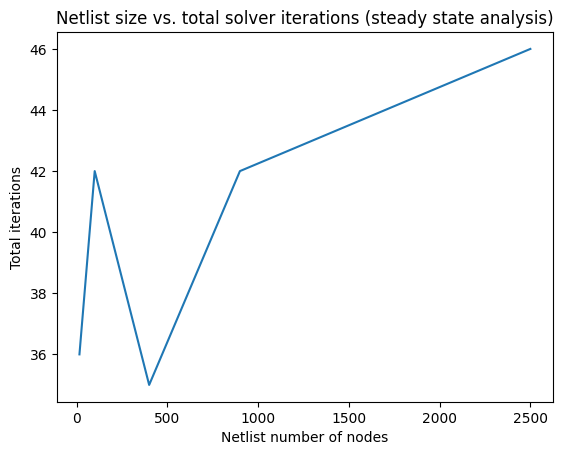

In [26]:
# plot netlist size vs. total iterations
import matplotlib.pyplot as plt
plt.plot([ss**2 for ss in NET_SIZES], [s['Total iterations'] for s in statistics.values()])
plt.xlabel("Netlist number of nodes")
plt.ylabel("Total iterations")
plt.title("Netlist size vs. total solver iterations (steady state analysis)")

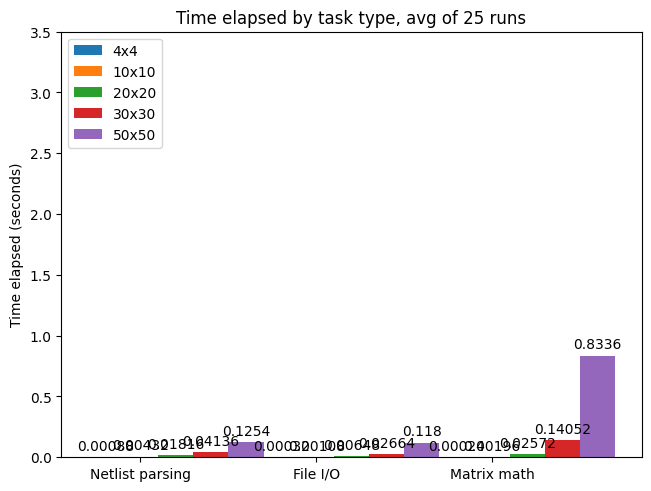

In [27]:
import matplotlib.pyplot as plt 

netlist_fields = ['Subckt and Param expansion time','Netlist parsing time']
loading_fields = ['Netlist loading time','Matrix load time','Transient load time']
matrix_fields = ['Matrix synchronize time','Matrix reorder time','Matrix factor time','Matrix solve time']

# grouped bar chart of size vs. time for each field
stat_totals = {
    size: [sum(statistics[str(size)][field] for field in netlist_fields),
    sum(statistics[str(size)][field] for field in loading_fields),
    sum(statistics[str(size)][field] for field in matrix_fields)]
    for size in NET_SIZES
}
all_fields = list(set(netlist_fields + loading_fields + matrix_fields))
trial_data = stat_totals

task_type = {"Netlist parsing": netlist_fields, "File I/O": loading_fields, "Matrix math": matrix_fields}

x = np.arange(len(task_type))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in trial_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=f"{attribute}x{attribute}")
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time elapsed (seconds)')
ax.set_title(f'Time elapsed by task type, avg of {n_iters} runs')
ax.set_xticks(x + width, task_type.keys())
ax.legend(loc='upper left', ncols=1)
ax.set_ylim(0, 3.5)

plt.show()

In [28]:
instance.ressource_usage().keys()

dict_keys(['Total elapsed time (seconds)', 'elapsed time since last call (seconds)', 'Total DRAM available', 'DRAM currently available', 'Maximum ngspice program size', 'Current ngspice program size', 'Number of lines in the deck', 'Netlist loading time', 'Subckt and Param expansion time', 'Netlist parsing time', 'Nominal temperature', 'Operating temperature', 'Total iterations', 'Transient iterations', 'Circuit Equations', 'Circuit original non-zeroes', 'Circuit fill-in non-zeroes', 'Circuit total non-zeroes', 'Transient timepoints', 'Accepted timepoints', 'Rejected timepoints', 'Total analysis time (seconds)', 'Matrix load time', 'Matrix synchronize time', 'Matrix reorder time', 'Matrix factor time', 'Matrix solve time', 'Transient analysis time', 'Transient load time', 'Transient sync time', 'Transient factor time', 'Transient solve time', 'Transient trunc time', 'Transient iterations for the last time point', 'AC analysis time', 'AC load time', 'AC sync time', 'AC factor time', 'AC

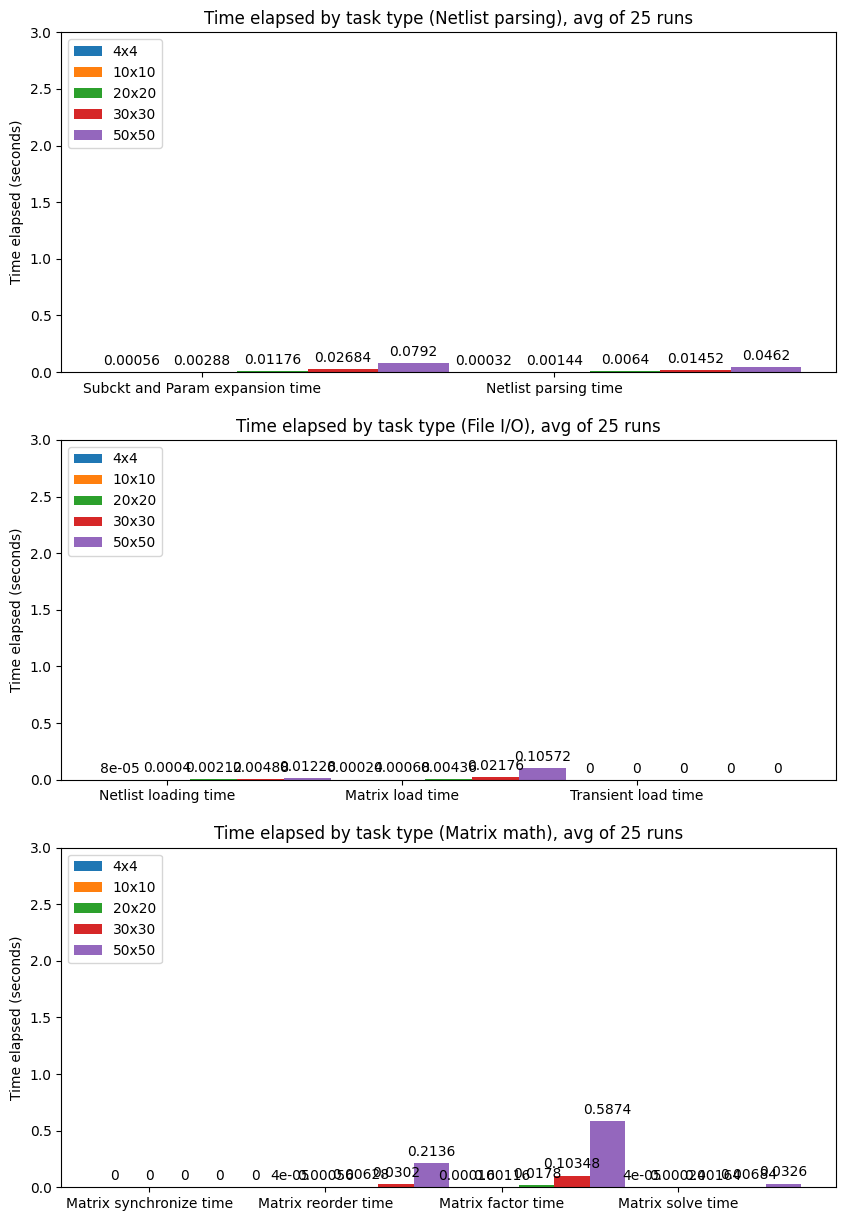

In [29]:
import matplotlib.pyplot as plt 

# grouped bar chart of size vs. time for each field
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

for i, (category, fields) in enumerate(zip(["Netlist parsing", "File I/O", "Matrix math"], [netlist_fields, loading_fields, matrix_fields])):
    stat_totals = {
        size: [statistics[str(size)][f] for f in fields]
        for size in NET_SIZES
    }

    x = np.arange(len(fields))  # the label locations
    width = 0.2  # the width of the bars
    multiplier = 0

    for attribute, measurement in stat_totals.items():
        offset = width * multiplier
        rects = axs[i].bar(x + offset, measurement, width, label=f"{attribute}x{attribute}")
        axs[i].bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    axs[i].set_ylabel('Time elapsed (seconds)')
    axs[i].set_title(f'Time elapsed by task type ({category}), avg of {n_iters} runs')
    axs[i].set_xticks(x + width, fields)
    axs[i].legend(loc='upper left', ncols=1)
    axs[i].set_ylim(0, 3)

plt.show()

## Comparing unoptimized vs. optimized code

In [31]:
baseline = json.load(open("profiling_baseline.json"))
opt1 = json.load(open("profiling_param_subckt.json"))
opt2 = json.load(open("profiling_globaldef.json"))


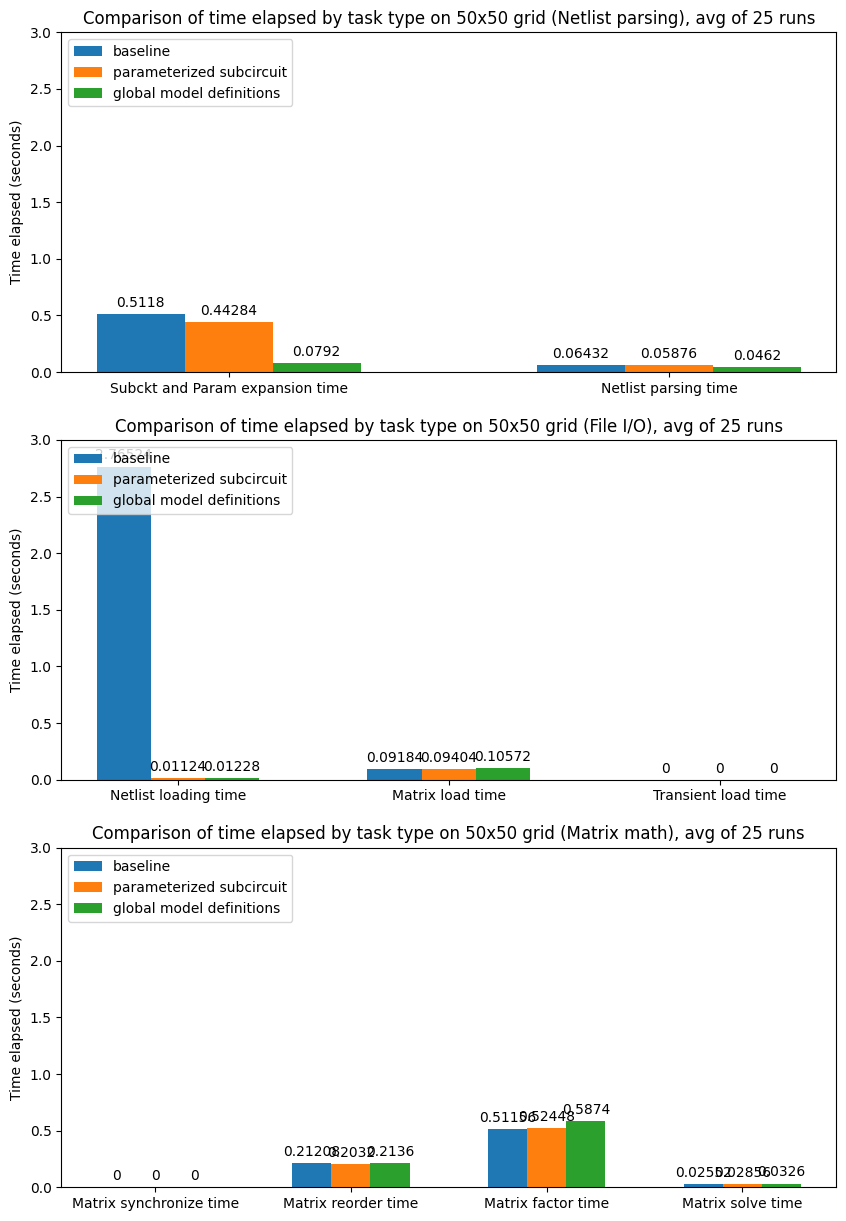

In [32]:
import matplotlib.pyplot as plt 

# grouped bar chart of size vs. time for each field
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

for i, (category, fields) in enumerate(zip(["Netlist parsing", "File I/O", "Matrix math"], [netlist_fields, loading_fields, matrix_fields])):
    stat_totals = {
        "baseline": [baseline['50'][f] for f in fields],
        "parameterized subcircuit": [opt1['50'][f] for f in fields],
        "global model definitions": [opt2['50'][f] for f in fields],
    }

    x = np.arange(len(fields))  # the label locations
    width = 0.2  # the width of the bars
    multiplier = 0

    for attribute, measurement in stat_totals.items():
        offset = width * multiplier
        rects = axs[i].bar(x + offset, measurement, width, label=f"{attribute}")
        axs[i].bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    axs[i].set_ylabel('Time elapsed (seconds)')
    axs[i].set_title(f'Comparison of time elapsed by task type on 50x50 grid ({category}), avg of {n_iters} runs')
    axs[i].set_xticks(x + width, fields)
    axs[i].legend(loc='upper left', ncols=1)
    axs[i].set_ylim(0, 3)

plt.show()

In [34]:
# compare number of equations, matrix nonzeros, and lines of netlist
print("Netlist lines")
print("  Baseline: ", [baseline[str(size)]['Netlist lines'] for size in NET_SIZES])
print("  Parameterized subcircuit: ", [opt1[str(size)]['Netlist lines'] for size in NET_SIZES])
print("  Global model: ", [opt2[str(size)]['Netlist lines'] for size in NET_SIZES])

print("Circuit Equations")
print("  Baseline: ", [baseline[str(size)]['Circuit Equations'] for size in NET_SIZES])
print("  Parameterized subcircuit: ", [opt1[str(size)]['Circuit Equations'] for size in NET_SIZES])
print("  Global model: ", [opt2[str(size)]['Circuit Equations'] for size in NET_SIZES])

print("Circuit original non-zeroes")
print("  Baseline: ", [baseline[str(size)]['Circuit original non-zeroes'] for size in NET_SIZES])
print("  Parameterized subcircuit: ", [opt1[str(size)]['Circuit original non-zeroes'] for size in NET_SIZES])
print("  Global model: ", [opt2[str(size)]['Circuit original non-zeroes'] for size in NET_SIZES])

print("Circuit fill-in non-zeroes")
print("  Baseline: ", [baseline[str(size)]['Circuit fill-in non-zeroes'] for size in NET_SIZES])
print("  Parameterized subcircuit: ", [opt1[str(size)]['Circuit fill-in non-zeroes'] for size in NET_SIZES])
print("  Global model: ", [opt2[str(size)]['Circuit fill-in non-zeroes'] for size in NET_SIZES])

Netlist lines
  Baseline:  [263, 1607, 6407, 14407, 40007]
  Parameterized subcircuit:  [46, 214, 814, 1814, 5014]
  Global model:  [46, 214, 814, 1814, 5014]
Circuit Equations
  Baseline:  [87.0, 506.0, 2006.0, 4506.0, 12506.0]
  Parameterized subcircuit:  [87.0, 506.0, 2006.0, 4506.0, 12506.0]
  Global model:  [87.0, 506.0, 2006.0, 4506.0, 12506.0]
Circuit original non-zeroes
  Baseline:  [373.0, 2305.0, 9205.0, 20705.0, 57505.0]
  Parameterized subcircuit:  [373.0, 2305.0, 9205.0, 20705.0, 57505.0]
  Global model:  [373.0, 2305.0, 9205.0, 20705.0, 57505.0]
Circuit fill-in non-zeroes
  Baseline:  [99.0, 1592.0, 11446.0, 32212.0, 119501.0]
  Parameterized subcircuit:  [99.0, 1592.0, 11446.0, 32212.0, 119501.0]
  Global model:  [99.0, 1592.0, 11446.0, 32212.0, 119501.0]


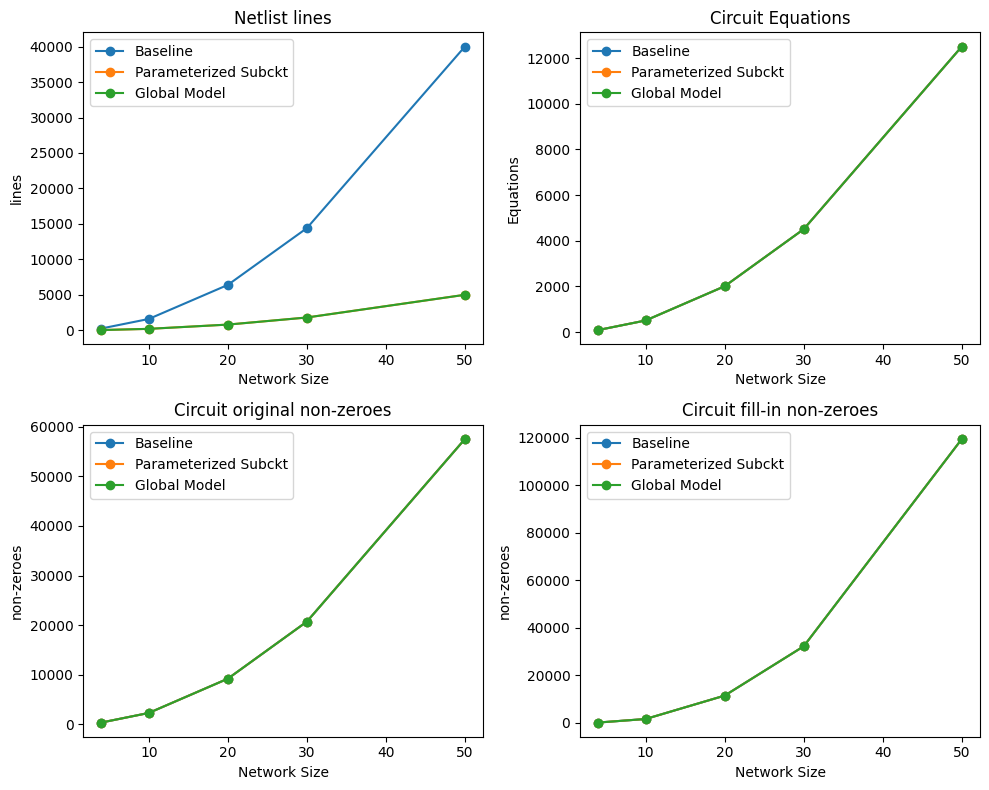

In [37]:
import matplotlib.pyplot as plt

# Data from your output
comp_fields = ['Netlist lines', 'Circuit Equations', 'Circuit original non-zeroes', 'Circuit fill-in non-zeroes']
data = {
    f: ([baseline[str(size)][f] for size in NET_SIZES], [opt1[str(size)][f] for size in NET_SIZES], [opt2[str(size)][f] for size in NET_SIZES])
    for f in comp_fields
}

# Plot configuration
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
titles = list(data.keys())

# Loop through and plot each metric
for i, (title, (baseline_metric, param_metric, global_metric)) in enumerate(data.items()):
    ax = axs[i // 2, i % 2]
    ax.plot(NET_SIZES, baseline_metric, label='Baseline', marker='o')
    ax.plot(NET_SIZES, param_metric, label='Parameterized Subckt', marker='o')
    ax.plot(NET_SIZES, global_metric, label='Global Model', marker='o')
    ax.set_title(title)
    ax.set_xlabel('Network Size')
    ax.set_ylabel(title.split()[-1])
    ax.legend()

plt.tight_layout()
plt.show()


In [50]:
# find factor reduction in num lines
baseline_lines = [baseline[str(size)]['Netlist lines'] for size in NET_SIZES]
param_lines = [optim1[str(size)]['Netlist lines'] for size in NET_SIZES]

line_reduction = [bl / pl for bl, pl in zip(baseline_lines, param_lines)]
line_reduction

[5.717391304347826,
 7.509345794392523,
 7.871007371007371,
 7.9421168687982355,
 7.979058635819705]

In [40]:
# compare total times of runs for each
clock_time_baseline = [sum(baseline[str(size)][f] for f in netlist_fields + loading_fields + matrix_fields) for size in NET_SIZES]
clock_time_opt1 = [sum(opt1[str(size)][f] for f in netlist_fields + loading_fields + matrix_fields) for size in NET_SIZES]
clock_time_opt2 = [sum(opt2[str(size)][f] for f in netlist_fields + loading_fields + matrix_fields) for size in NET_SIZES]

print(clock_time_baseline)
print(clock_time_opt1)
print(clock_time_opt2)

speedups = [clock_time_baseline[i] / (clock_time_opt2[i]+1e-10) for i in range(len(NET_SIZES))]
speedups

[0.0020800000000000007, 0.01568000000000001, 0.13568, 0.6002800000000001, 4.18236]
[0.0015600000000000006, 0.010520000000000005, 0.059720000000000016, 0.217, 1.36312]
[0.0014400000000000003, 0.007360000000000002, 0.05036000000000002, 0.2085200000000001, 1.077]


[1.4444443441358095,
 2.130434753662572,
 2.6942017420687003,
 2.878764625513732,
 3.883342618023831]

In [61]:
# plt.plot(NET_SIZES[1:], speedups[1:], label="Speedup")
# plt.plot(NET_SIZES, clock_time_baseline, label="Baseline")
# plt.plot(NET_SIZES, clock_time_optim1, label="Optimized")

# plt.xlabel("Netlist number of nodes")
# plt.ylabel("Total time elapsed (s)")
# plt.title("Total time elapsed vs. netlist size")